# XAI Pipeline for Skin Cancer Classification
This notebook loads the trained Xception model, applies there XAI methods (Grad-CAM, SHAP, Influence Functions), and exports the results in a format ready for the LLM integration pipeline.

## Import Libraries

In [2]:
# --- 1. Setup and Initialization ---
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if project_root not in sys.path:
    sys.path.append(project_root)
    print(f"Project root added to path: {project_root}")

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from captum.attr import LayerGradCam, Occlusion, IntegratedGradients
from captum.attr import visualization as viz
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Import the model architecture from our central definition file
from src.model_def import SkinCancerViT

print("Libraries imported successfully.")

Project root added to path: /Users/berkay/Projects/thesis-project


/Users/berkay/Projects/thesis-project/thesis-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/berkay/Projects/thesis-project/thesis-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries imported successfully.


## Define Project Structure and File Paths

In [3]:
# --- 2. Define Project Structure and File Paths ---

BASE_DIR = project_root
MODEL_PATH = os.path.join(BASE_DIR, 'models', 'temp', 'ViT-class_weights.pth')
SAMPLE_IMAGE_PATH = os.path.join(BASE_DIR, 'user_inputs', 'user_sample1.jpg')
PROCESSED_TRAIN_DATA_PATH = os.path.join(BASE_DIR, 'data', 'processed', 'ViT', 'train_dataset.pt')
TRAIN_SPLIT_PATH = os.path.join(BASE_DIR, 'data', 'processed', 'train_split.csv')
OUTPUT_DIR = os.path.join(BASE_DIR, 'results', 'xai_output')
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Project Base Directory: {BASE_DIR}")
print(f"Using Model Path: {MODEL_PATH}")

Project Base Directory: /Users/berkay/Projects/thesis-project
Using Model Path: /Users/berkay/Projects/thesis-project/models/temp/ViT-class_weights.pth


## Model Definition and Loading

In [4]:
# --- 3. Model Definition and Loading (Final, Corrected Version) ---
print("\nLoading model...")

# Instantiate the model from our central definition file
model = SkinCancerViT(num_classes=2)
try:
    model.load_state_dict(torch.load(MODEL_PATH))
    model.eval()
    print(f"Successfully loaded trained model weights.")
except Exception as e:
    print(f"An error occurred while loading the model state_dict: {e}")


Loading model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at Anwarkh1/Skin_Cancer-Image_Classification and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([7]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([7, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successfully loaded trained model weights.


## Data Loading and Preprocessing

In [5]:
# --- 4. Data Loading and Preprocessing ---

print("\nLoading and preprocessing sample image...")

# The model expects 224x224 images
preprocess_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
try:
    input_image = Image.open(SAMPLE_IMAGE_PATH).convert('RGB')
    input_tensor = preprocess_transform(input_image).unsqueeze(0)
    print(f"Successfully loaded sample image: {SAMPLE_IMAGE_PATH}")
except FileNotFoundError:
    print(f"ERROR: Sample image not found at '{SAMPLE_IMAGE_PATH}'")


Loading and preprocessing sample image...
Successfully loaded sample image: /Users/berkay/Projects/thesis-project/user_inputs/user_sample1.jpg


## XAI Pipeline Implementation

In [6]:
# --- 5. XAI Pipeline Implementation ---

print("\n--- Running XAI Pipeline ---")

# Get model prediction
logits = model(input_tensor).logits
output_softmax = F.softmax(logits, dim=1)
prediction_score, pred_label_idx = torch.topk(output_softmax, 1)
predicted_class_index = pred_label_idx.squeeze().item()
class_names = ['Benign', 'Malignant']
print(f"Model Prediction: Class '{class_names[predicted_class_index]}' with confidence {prediction_score.item():.2%}")


--- Running XAI Pipeline ---
Model Prediction: Class 'Benign' with confidence 76.39%


### Grad-CAM Implementation


--- Generating Grad-CAM ---


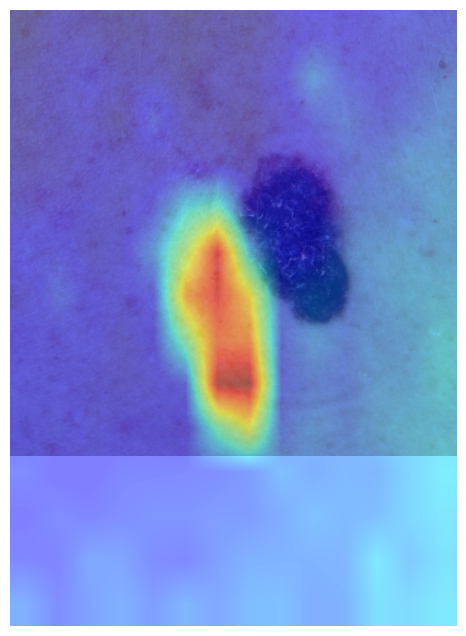

Grad-CAM image saved to: /Users/berkay/Projects/thesis-project/results/xai_output/user_sample1_xai_gradcam.png


In [7]:
# --- 5a. Grad-CAM Implementation ---
print("\n--- Generating Grad-CAM ---")

# We target the initial convolutional layer that processes the image patches.
# This layer is compatible with the standard Grad-CAM algorithm.
grad_cam_layer = model.vit_model.vit.embeddings.patch_embeddings.projection

def model_forward_wrapper(input_tensor):
    """Wrapper to return only the logits tensor from the model's output."""
    return model(input_tensor).logits

layer_gc = LayerGradCam(model_forward_wrapper, grad_cam_layer)
attribution_gc = layer_gc.attribute(input_tensor, target=predicted_class_index)

# The output from the convolutional layer is already a 2D feature map,
# so we can resize it directly without token reshaping.
heatmap = F.interpolate(attribution_gc, size=input_image.size, mode='bilinear', align_corners=False)
heatmap = heatmap.squeeze().cpu().detach().numpy()

# Plotting and saving the Grad-CAM image
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(input_image)
ax.imshow(heatmap, cmap='jet', alpha=0.5)
ax.axis('off')

grad_cam_output_path = os.path.join(OUTPUT_DIR, 'user_sample1_xai_gradcam.png')
plt.savefig(grad_cam_output_path, bbox_inches='tight', pad_inches=0)
plt.show()
print(f"Grad-CAM image saved to: {grad_cam_output_path}")

### SHAP


--- Generating SHAP ---


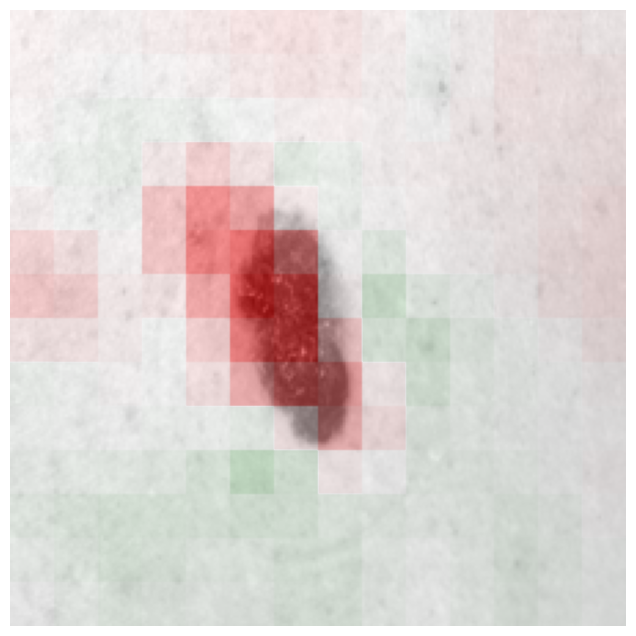

SHAP image saved to: /Users/berkay/Projects/thesis-project/results/xai_output/user_sample1_xai_shap.png


In [8]:
# --- 5b. SHAP ---
print("\n--- Generating SHAP ---")

occlusion = Occlusion(model_forward_wrapper) # Use the wrapper here too for consistency
attribution_shap = occlusion.attribute(input_tensor, strides=(3, 16, 16), target=predicted_class_index, sliding_window_shapes=(3, 32, 32), baselines=0)

fig_shap, ax_shap = plt.subplots(figsize=(8, 8))
ax_shap.axis('off')
viz.visualize_image_attr(np.transpose(attribution_shap.squeeze().cpu().detach().numpy(), (1,2,0)), np.array(input_image.resize((224,224))), method="blended_heat_map", sign="all", show_colorbar=False, plt_fig_axis=(fig_shap, ax_shap))
shap_output_path = os.path.join(OUTPUT_DIR, 'user_sample1_xai_shap.png')
fig_shap.savefig(shap_output_path, bbox_inches='tight', pad_inches=0)
plt.show()
print(f"SHAP image saved to: {shap_output_path}")

### Influence Functions

In [9]:
# --- 5c. Influence Functions ---
print("\n--- Generating Influence Functions ---")

def get_gradient_and_prediction(model, data_tensor, target, loss_fn):
    model.zero_grad()
    logits = model(data_tensor).logits
    _, pred_idx = torch.max(logits.data, 1)
    loss = loss_fn(logits, target)
    loss.backward()
    grad = model.vit_model.classifier.weight.grad.detach().clone()
    return grad.flatten(), pred_idx.item()

def calculate_real_influence(model, train_loader, test_tensor, test_target, device):
    model.to(device)
    model.eval()
    test_tensor = test_tensor.to(device)
    test_target = torch.tensor([test_target]).to(device)
    loss_fn = nn.CrossEntropyLoss()
    print("Calculating gradient for the test image...")
    test_grad, _ = get_gradient_and_prediction(model, test_tensor, test_target, loss_fn)
    results = []
    print("Iterating through the training dataset...")
    for train_imgs, train_labels in tqdm(train_loader):
        train_imgs, train_labels = train_imgs.to(device), train_labels.to(device)
        for i in range(len(train_imgs)):
            train_grad, train_pred = get_gradient_and_prediction(model, train_imgs[i].unsqueeze(0), train_labels[i].unsqueeze(0), loss_fn)
            influence_score = torch.dot(test_grad, train_grad).item()
            results.append({'score': influence_score, 'prediction': train_pred})
    return results

try:
    print(f"Loading processed training data from: {PROCESSED_TRAIN_DATA_PATH}")
    processed_data = torch.load(PROCESSED_TRAIN_DATA_PATH)
    train_images, train_labels = processed_data['images'], processed_data['labels']
    train_df = pd.read_csv(TRAIN_SPLIT_PATH)
    train_filenames = train_df['DDI_file'].tolist()
    train_dataset = TensorDataset(train_images, train_labels)
    train_loader = DataLoader(train_dataset, batch_size=32)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    influence_results = calculate_real_influence(model, train_loader, input_tensor, predicted_class_index, device)
    
    report_data = [{'case_id': train_filenames[i].split('.')[0], 'influence_score': r['score'], 'ground_truth': train_labels[i].item(), 'prediction': r['prediction']} for i, r in enumerate(influence_results)]
    report_df = pd.DataFrame(report_data)
    report_df['abs_influence'] = report_df['influence_score'].abs()
    report_df = report_df.sort_values(by='abs_influence', ascending=False).drop(columns='abs_influence')
    final_report_df = report_df.head(100)

    influence_output_path = os.path.join(OUTPUT_DIR, 'user_sample1_influence_function.csv')
    final_report_df.to_csv(influence_output_path, index=False)
    print(f"\nSuccessfully saved {len(final_report_df)} real influence scores to: {influence_output_path}")
    
except FileNotFoundError as e:
    print(f"ERROR: A required data file was not found. Please ensure notebooks 01 and 02 have been run. Details: {e}")

print("\n\n--- XAI Pipeline Execution Complete ---")


--- Generating Influence Functions ---
Loading processed training data from: /Users/berkay/Projects/thesis-project/data/processed/ViT/train_dataset.pt
Calculating gradient for the test image...
Iterating through the training dataset...


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [06:22<00:00, 29.39s/it]


Successfully saved 100 real influence scores to: /Users/berkay/Projects/thesis-project/results/xai_output/user_sample1_influence_function.csv


--- XAI Pipeline Execution Complete ---
